#**Capstone project: Can ML Outperform Market-Neutral Trading in Structural Breaks?**

**Note:**

It's a good practise to "restart the session", whenever changes are made to the github repository


##**Step 1:** GitHub setup

1) Clone/Update the projects github repository

In [ ]:
# Use for the first time to clone the github repo or when the repo is updated
%rm -rf /content/MarketNeutral_Trading/
%cd /content
!git clone https://github.com/WQU-Capstone-11205/MarketNeutral_Trading.git
%cd /content/MarketNeutral_Trading

/content
Cloning into 'MarketNeutral_Trading'...
remote: Enumerating objects: 980, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 980 (delta 15), reused 5 (delta 5), pack-reused 953 (from 3)
Receiving objects: 100% (980/980), 1.86 MiB | 16.02 MiB/s, done.
Resolving deltas: 100% (546/546), done.
/content/MarketNeutral_Trading


2) Add the project's github repository's path to the system path

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('/content/MarketNeutral_Trading')

3) Install projects required packages

In [ ]:
!pip install -r requirements.txt

##**Step 2:** Data loading

Load data and convert to distance spread

In [ ]:
from data_loading.fetch_data import fetch_from_yfinance
from data_loading.distance_spread import distance_spread
from util.split_time_series import split_time_series
from util.ff_benchmark import get_ff_benchmark_returns

# Example pair: XLF and FAS (Financial sector ETFs, often cointegrated)
ticker1 = 'XLF'
ticker2 = 'FAS'# Note: FAS is a leveraged ETF, may require careful handling/interpretation
start_date = '2005-01-01'
end_date = '2025-01-01'
# Use an in-sample period for training the cointegration relationship
in_sample_cutoff_date = '2017-01-01' # After this date the cointegration fails

# Fetch a benchmark for alpha/beta calculation (e.g., SPY)
benchmark_data = fetch_from_yfinance(['SPY'], start_date, end_date)
benchmark_returns = benchmark_data.pct_change().dropna()
train_spy_returns = benchmark_returns.loc[:in_sample_cutoff_date]
test_spy_returns = benchmark_returns.loc[in_sample_cutoff_date:]
ff_benchmark_returns = get_ff_benchmark_returns(in_sample_cutoff_date, end_date)

spread = distance_spread([ticker1, ticker2], start_date=start_date, end_date=end_date)
train_spread = spread.loc[:in_sample_cutoff_date]
test_spread = spread.loc[in_sample_cutoff_date:]
spread_returns = spread.pct_change().dropna()
train_spread_returns = spread_returns.loc[:in_sample_cutoff_date]
test_spread_returns = spread_returns.loc[in_sample_cutoff_date:]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  2 of 2 completed


##**Step 3:** Hyperparameter tuning of BOCPD+VAE+RL pipeline

Tune hyper-parameter for BOCPD+VAE+RL pipeline.

In [ ]:
bocpd_space = {
    "hazard": [15],#15
    "mu": [0],
    "kappa": [0.3],
    "alpha": [1.0],
    "beta": [0.8]
}

vae_space = {
    "input_dim": [2],
    "latent_dim": [12],
    "hidden_dim": [256],
    "lr": [0.001],
    "vae_seq_len": [1],
    "kl_wt": [0.01]
}

rl_space = {
    "state_dim": [12],
    "action_dim": [1],
    "hidden_dim": [64],
    "lr": [1e-4],
    "gamma": [0.99],
    "cp_weight": [0.08],
    "var_penalty": [1e-5],
    "var_window": [20],
    "dd_penalty": [0.0],
    "dd_threshold": [0.10]
}

joint_space = {
    "state_window": [25],
    "base_action_sigma": [0.5],
    "wt_multplier": [1.2],
    "buffer_size_updates": [256],
    "sample_batch_size": [64],
    "transaction_cost": [0.001],
    "tc_scale": [1.0],
    "exploration_alpha": [6.5],
}

from tuning.bocpd_vae_rl_tuner import BOCPD_VAE_RL_Tuner

bocpd_vae_rl_tuner = BOCPD_VAE_RL_Tuner(bocpd_space, vae_space, rl_space, joint_space)

bocpd_vae_rl_tuner.tune(train_spread)
bocpd_params, vae_params, rl_params, joint_params = bocpd_vae_rl_tuner.best_params

print(f'bocpd_params = {bocpd_params}')
print(f'vae_params = {vae_params}')
print(f'rl_params = {rl_params}')
print(f'joint_params = {joint_params}')


bocpd score = -8 :: params = {'hazard': 15, 'mu': 0, 'kappa': 0.3, 'alpha': 1.0, 'beta': 0.8}
Best BOCPD parameters: {'hazard': 15, 'mu': 0, 'kappa': 0.3, 'alpha': 1.0, 'beta': 0.8}
Best BOCPD score: -8
vae score = -71.2136 :: params = {'input_dim': 2, 'latent_dim': 12, 'hidden_dim': 256, 'lr': 0.001, 'vae_seq_len': 1, 'kl_wt': 0.01}
Best vae parameters: {'input_dim': 2, 'latent_dim': 12, 'hidden_dim': 256, 'lr': 0.001, 'vae_seq_len': 1, 'kl_wt': 0.01}
Best vae score: -71.2136
RL score = -0.4984 :: params = {'state_dim': 12, 'action_dim': 1, 'hidden_dim': 64, 'lr': 0.0001, 'gamma': 0.99, 'cp_weight': 0.08, 'var_penalty': 1e-05, 'var_window': 20, 'dd_penalty': 0.0, 'dd_threshold': 0.1}
Best RL parameters: {'state_dim': 12, 'action_dim': 1, 'hidden_dim': 64, 'lr': 0.0001, 'gamma': 0.99, 'cp_weight': 0.08, 'var_penalty': 1e-05, 'var_window': 20, 'dd_penalty': 0.0, 'dd_threshold': 0.1}
Best RL score: -0.4984
Joint Tuning score = 0.3433 :: params = {'state_window': 25, 'base_action_sigma': 

First we tuned with the BOCPD_VAE_RL_Tuner.tune(). It was found that VAE reconstructed output was not matching the input spread and hence had to manually tune few VAE parameters, so the reconstructed matches the input spread.

The best parameters are now stored in the BOCPD_VAE_RL_Tuner class. These can directly be used without tuning the model again. The model's complete automatic tuning takes roughly around 3-4 hours.

##**Step 4:** Training of BOCPD+VAE+RL pipeline

This task takes around 45 minutes.

In [ ]:
from train.train_loop_rl import train_loop_rl

train_loop_rl(train_spread, bocpd_params, vae_params, rl_params, joint_params, num_epochs=50)

100%|██████████| 2042/2042 [00:28<00:00, 72.25it/s]


Stop-loss triggered for 4 PnLs
Epoch 000 | recon loss = 0.0327 | kl loss = 0.0370 | policy loss = 0.0000
Sharpe = -0.357
Saved all models + optimizers
Saved best models at epoch 000 (Sharpe=-0.357)


100%|██████████| 2042/2042 [00:29<00:00, 68.41it/s]


Epoch 001 | recon loss = 0.0098 | kl loss = 0.1414 | policy loss = -0.0001
Sharpe = 0.646
Saved all models + optimizers
Saved best models at epoch 001 (Sharpe=0.646)


100%|██████████| 2042/2042 [00:31<00:00, 63.94it/s]


Stop-loss triggered for 6 PnLs
Epoch 002 | recon loss = 0.0012 | kl loss = 0.0963 | policy loss = -0.0001
Sharpe = -0.157
No improvement. Early stopping patience counter = 1/5


100%|██████████| 2042/2042 [00:32<00:00, 63.62it/s]


Stop-loss triggered for 4 PnLs
Epoch 003 | recon loss = 0.0014 | kl loss = 0.0613 | policy loss = 0.0001
Sharpe = -0.006
No improvement. Early stopping patience counter = 2/5


100%|██████████| 2042/2042 [00:35<00:00, 57.57it/s]


Stop-loss triggered for 7 PnLs
Epoch 004 | recon loss = 0.0009 | kl loss = 0.0416 | policy loss = 0.0000
Sharpe = -0.131
No improvement. Early stopping patience counter = 3/5


100%|██████████| 2042/2042 [00:34<00:00, 58.62it/s]


Stop-loss triggered for 7 PnLs
Epoch 005 | recon loss = 0.0013 | kl loss = 0.0371 | policy loss = 0.0001
Sharpe = -0.396
No improvement. Early stopping patience counter = 4/5


100%|██████████| 2042/2042 [00:35<00:00, 57.18it/s]


Stop-loss triggered for 6 PnLs
Epoch 006 | recon loss = 0.0009 | kl loss = 0.0319 | policy loss = -0.0002
Sharpe = -0.120
No improvement. Early stopping patience counter = 5/5
EARLY STOPPING TRIGGERED at epoch 6
Training stopped early due to no improvement in Sharpe.
RL policy training complete.


##**Step 5:** Testing of BOCPD+VAE+RL pipeline:

In [ ]:
from backtest.evaluate_loop_rl import evaluate_loop_rl

test_metrics = evaluate_loop_rl(test_spread, bocpd_params, vae_params, rl_params, joint_params)

Loaded models/opts


100%|██████████| 2011/2011 [00:05<00:00, 379.53it/s]


RMSE channel0 (spread, denorm): 1.342056
RMSE channel1 (cp prob):        0.062585
Evaluation complete.


##**Step 6:** Test metrics BOCPD+VAE+RL pipeline:

In [ ]:
import numpy as np
from metrics.stats import sharpe_ratio, compute_max_drawdown, sortino_ratio, annual_volatility, alpha_beta

print("Test metrics for BOCPD+VAE+RL model:")
cum_pnl = np.cumsum(test_metrics['portfolio_returns'])
print(f"Cummulative profit and loss                       : {cum_pnl[-1]:.6f}")
print(f"Sharpe Ratio                                      : {sharpe_ratio(test_metrics['portfolio_returns']):.6f}")
print(f"Sortino ratio                                     : {sortino_ratio(test_metrics['portfolio_returns']):.6f}")
print(f"Max drawdown                                      : {compute_max_drawdown(np.cumsum(test_metrics['portfolio_returns'])):.6f}")
print(f"Annual Volatility                                 : {annual_volatility(test_metrics['portfolio_returns']):.6f}")
alpha_ff, beta_ff = alpha_beta(test_metrics['portfolio_returns'], ff_benchmark_returns)
print(f"Factor-adjusted Alpha-Beta                        : alpha = {alpha_ff:.6f} , beta = {beta_ff:.6f}")
alpha_spy, beta_spy = alpha_beta(test_metrics['portfolio_returns'], test_spy_returns)
print(f"CAPM Alpha-Beta versus SPY                        : alpha = {alpha_spy:.6f} , beta = {beta_spy:.6f}")

Test metrics for BOCPD+VAE+RL model:
Cummulative profit and loss                       : 12.952011
Sharpe Ratio                                      : 0.542928
Sortino ratio                                     : 2.437613
Max drawdown                                      : 0.193495
Annual Volatility                                 : 2.989394
Factor-adjusted Alpha-Beta                        : alpha = 1.588300 , beta = 0.259480
CAPM Alpha-Beta versus SPY                        : alpha = 1.583677 , beta = 0.254165


**Results Summary**
1. Profitability: It has positive cumulative profit & loss. Hence the model is profitable.
2. Risk-Adjusted Returns: The Sharpe Ratio is better and it has very low downside risk due to high Sortino ratio. The model is good at avoiding drawdowns, even if the volatility is moderate.
3. Risk profile: The risk profile is good as the max drawdown is small. So, drawdowns exist but are not large. The annual volatility is also low, as returns are generated conversatively.
4. Factor Exposure: As per the factor adjusted Alpha, the model produces excess return, and does not depened on market exposure. It's consistent with a market-neutral strategy. The strategy is mostly decoupled from SPY index, which shows a strong model based returns than as per market movement.

Overall:
- This model is very stable and has a regime-aware trading behavior. It's consistent with BOCPD + latent smoothing
- It has consistent low drawdowns and downside risk are extremely well-controlled
- It has a positive alpha for factor-adjusted and CAPM benchmark. The beta is low, which says that it has diversified return source


##**Step 7:** Plots for BOCPD+VAE+RL pipeline
##7.1) **Original vs Reconstructed Spread (VAE):**

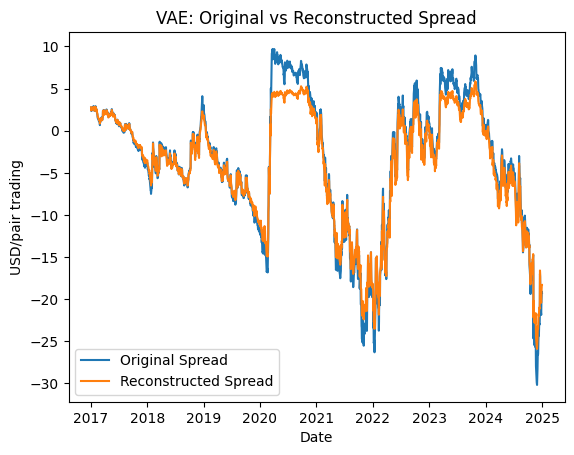

In [ ]:
from plots.bocpd_vae_rl import vae_plot

vae_plot(test_spread, test_metrics['recons'])

## 7.2) **Drawdown for portfolio returns:**

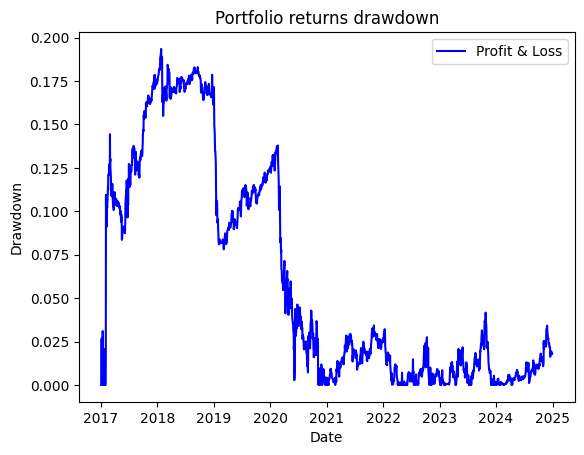

In [ ]:
from plots.bocpd import drawdown_plot

drawdown_plot(test_metrics['rets'])

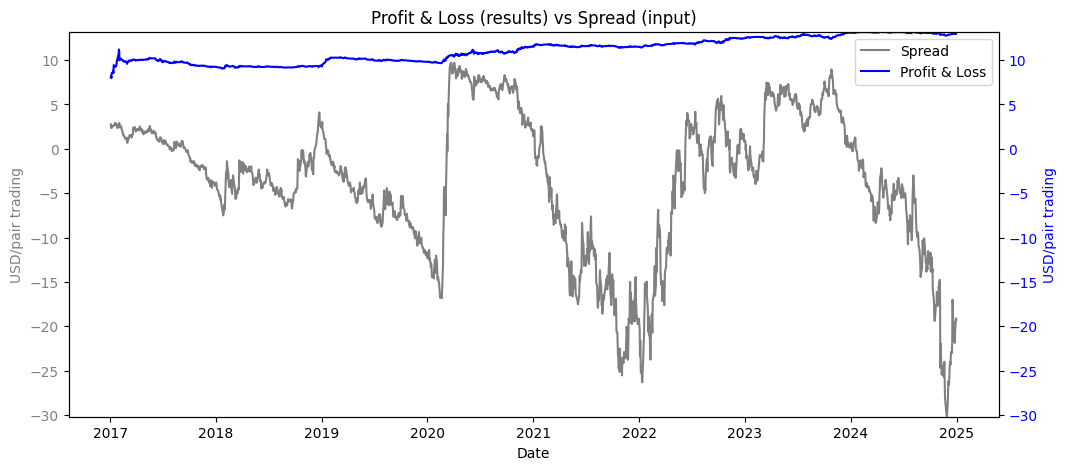

In [ ]:
from plots.bocpd import compare_trends_plot

cumpnl = np.cumsum(test_metrics['portfolio_returns'])
compare_trends_plot(test_spread, cumpnl)

**From the plot:**

- The gray line represents the spread (left y-axis), and the blue line represents the cumulative PnL (profit and loss) of the BOCPD+VAE+RL model (right y-axis).

- The PnL (blue) rises steadily during periods where the spread trends or exhibits strong mean-reverting behavior (e.g., 2017-2019 and again from 2022-2025), showing that the model is capturing profitable regimes.

- Around 2020, there's a drop in PnL corresponding to a regime shift or structural break in the spread — likely a detected high-change-probability zone where the RL agent temporarily misadapted.

- After 2021, the PnL stabilizes and then grows again, meaning the BOCPD+VAE combination successfully re-adapted to the new regime.

- The model's PnL curve being mostly upward with some flat or drawdown zones indicates that the hybrid model adjusts to regime changes and continues to accumulate profits overall, even though it occasional has sharp losses during transition periods.

**Summary:**
The plot shows that your BOCPD+VAE+RL system learns to exploit stable regimes profitably, experiences drawdowns during regime shifts, but overall maintains a positive, adaptive trading performance over time.

## 7.3) **Change Probability over time plot for BOCPD+VAE+RL pipeline:**

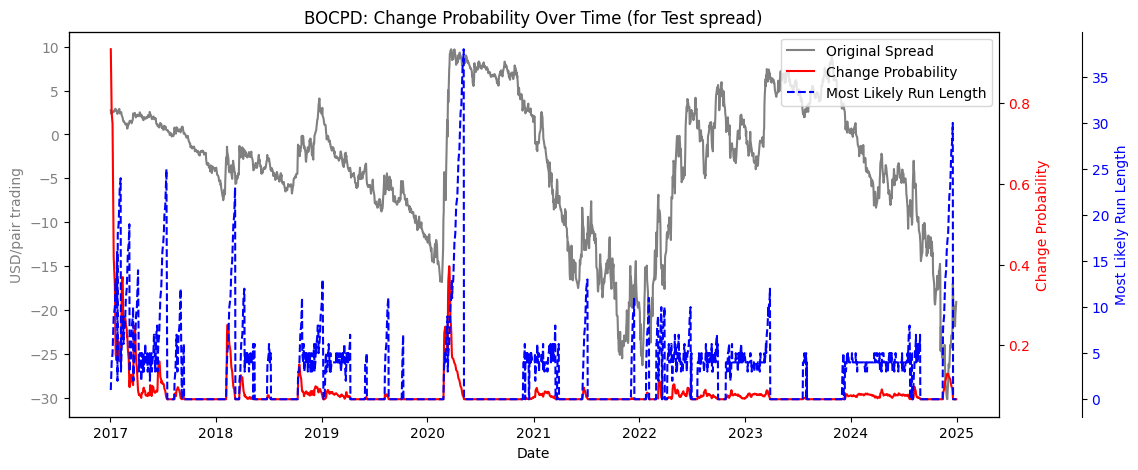

In [ ]:
from plots.bocpd import plot_rt_change_probs

plot_rt_change_probs(test_spread, test_metrics['rt_mle'], test_metrics['change_probs'])

##**Step 8:** Metrics (Out-Of-Sample data)
##8.1) **Policy stability metrics:**

In [ ]:
from metrics.policy_stability import policy_stability_metrics

perf_metric = policy_stability_metrics(test_metrics['actions'], eps=1e-3)
print("Policy stability metrics:")
print(f"Reversal rate per step    : {round(perf_metric['reversal_rate_per_step'],4)}")
print(f"Autocorrelation at lag-1  : {round(perf_metric['acf1'],4)}")


Policy stability metrics:
Reversal rate per step    : 0.0134
Autocorrelation at lag-1  : 0.9936


##8.2) **Adaptation Lag metrics:**

In [ ]:
from plots.adaptation_lags import plot_stabilization_lag_distributions, plot_variance_vs_lag
from metrics.policy_stability import compute_adaptation_lags, generate_stabilization_lag_report

change_indices = np.where(test_metrics['cp_flags'] == 1)[0]
details = compute_adaptation_lags(test_spread.index, test_metrics['portfolio_returns'], test_metrics['change_probs'], test_metrics['cp_flags'])
df, summary = generate_stabilization_lag_report(details)
print("Stabilization metrics (portfolio returns):")
print(f'mean_stabilization_lag : {round(summary['mean_stabilization_lag'],4)}')
print(f'p95_stabilization_lag : {round(summary['p95_stabilization_lag'],4)}')



Stabilization metrics (portfolio returns):
mean_stabilization_lag : 16.75
p95_stabilization_lag : 60.3


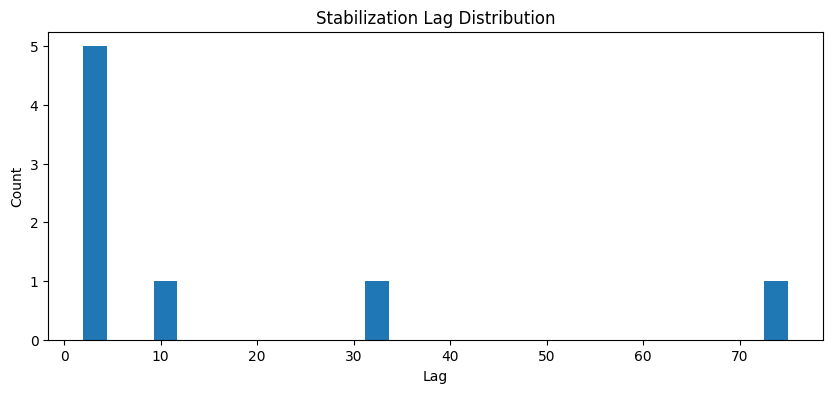

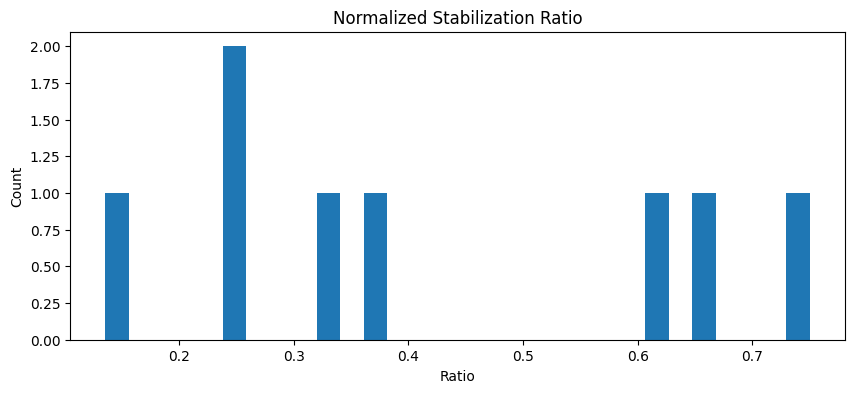

In [ ]:
plot_stabilization_lag_distributions(df)


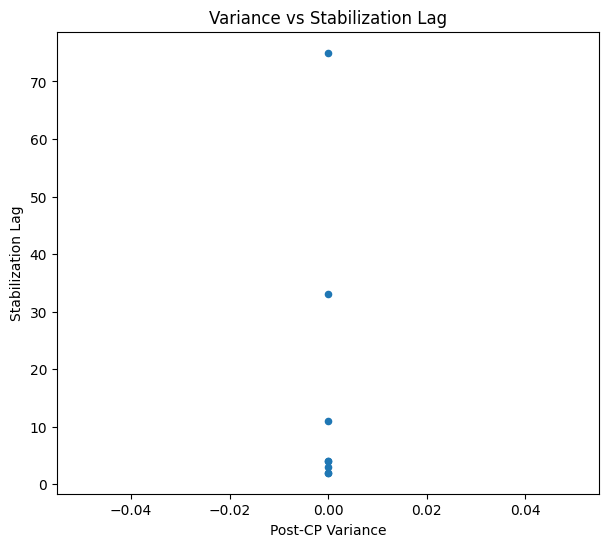

In [ ]:
plot_variance_vs_lag(df)